In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

In [38]:
df = pd.read_csv("/home/wak/toprak-lab/aml_drug_synergy/dump/sigmoid_synergy_estimations/bliss_v_observed_8_delta_ic50.csv")
print('Total drug pairs:', df[df['valid'] == 'VALID'].groupby(['drugA','drugB'])['dIC50'].mean().shape[0])
print('total number of drug combinations:', sum(df['valid'] == 'VALID'))
print('Total number of viability measurements:',sum(df['valid'] == 'VALID')*64)
df = df[df['valid']=='VALID']
df

Total drug pairs: 119
total number of drug combinations: 3167
Total number of viability measurements: 202688


,cell_line,drugA,drugB,drugB_conc,dIC50,valid
232,FKH1,6TG,6TG,0.000000,-0.067187,VALID
233,FKH1,6TG,6TG,2.980232,-0.652152,VALID
234,FKH1,6TG,6TG,4.768372,-0.668315,VALID
235,FKH1,6TG,6TG,7.629395,-0.745679,VALID
236,FKH1,6TG,6TG,12.207030,-0.278836,VALID
...,...,...,...,...,...,...
5633,Kasumi1,VP16,VP16,0.004100,-0.156507,VALID
5634,Kasumi1,VP16,VP16,0.010200,-0.181796,VALID
5635,Kasumi1,VP16,VP16,0.025600,-0.559810,VALID
5636,Kasumi1,VP16,VP16,0.064000,-0.244749,VALID


In [39]:
def classify_max(x):
    if np.median(x[1:])>0:
        return np.max(x)
    elif np.median(x[1:])<0:
        return np.min(x)
    else:
        return np.nanmedian(x[1:])
df_max = df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(classify_max).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]
df_max['dIC50'] = -df_max['dIC50'] 
df_max

/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,cell_line,drugA,drugB,dIC50
1,FKH1,6TG,ABT199,2.124312
2,FKH1,6TG,AG221,1.762509
3,FKH1,6TG,AZC,-1.343553
4,FKH1,6TG,AraC,-2.160773
5,FKH1,6TG,DAC,-0.516877
...,...,...,...,...
477,TF1,IDA,Mito,-4.568548
478,TF1,IDA,VP16,-0.849882
479,TF1,MTX,Mito,NaN
480,TF1,MTX,VP16,0.090148


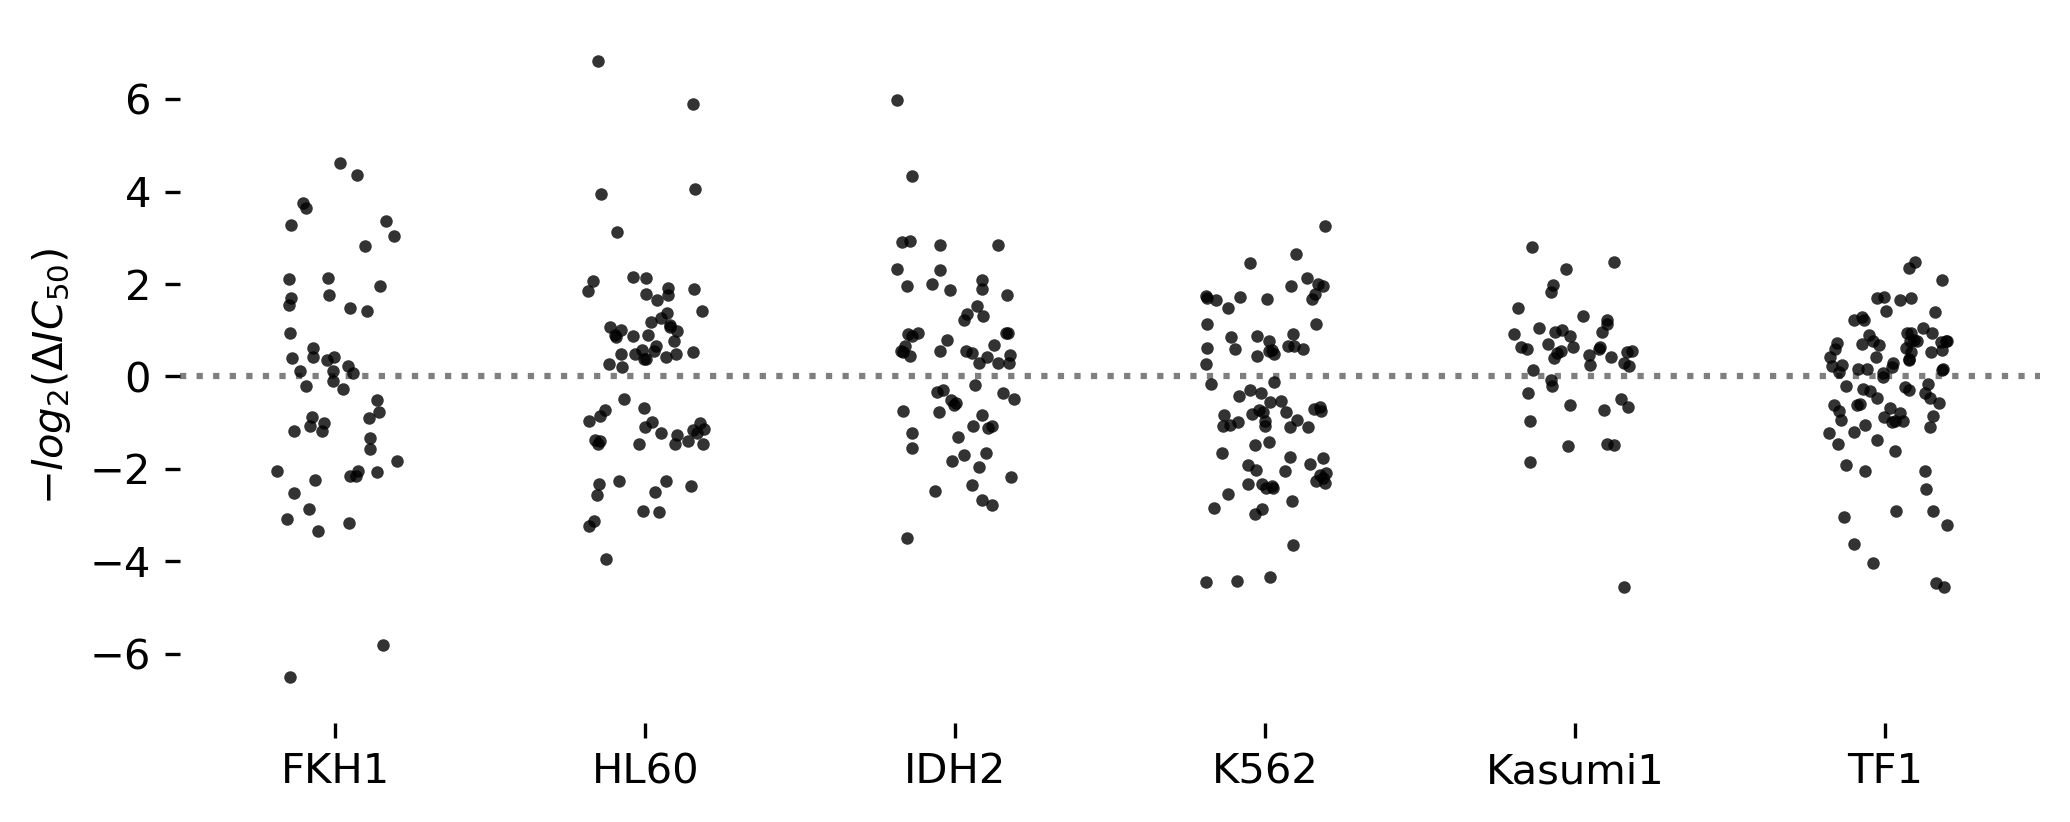

In [109]:
# Initialize the figure
f, ax = plt.subplots(figsize=(8,3),dpi=300)
sns.despine(bottom=True, left=True)
# Show each observation with a scatterplot
sns.stripplot(
    data=df_max, x="cell_line", y="dIC50",
    dodge=True, alpha=.8, zorder=1, legend=False,
    color='black', jitter=0.2, s=3
)
# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
# sns.pointplot(
#     data=df_max, x="cell_line", y="dIC50",
#     join=False, dodge=.8 - .8 / 3, color='darkblue',
#     markers="d", scale=.75, errorbar=None
# )
ax.plot([-0.5,6],[0,0],':',alpha=0.5, color='black', zorder=0)
# ax.plot([-0.5,6],[1,1],'-',alpha=0.5, color='red', zorder=0)
# ax.plot([-0.5,6],[-1,-1],'-',alpha=0.5, color='blue', zorder=0)
ax.set_ylim([-7.5,7.5])
ax.set_xlim([-0.5,5.5])
ax.set_ylabel('$-log_2(\Delta IC_{50})$')
ax.set_xlabel('')
# # Improve the legend
# sns.move_legend(
#     ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0
# )
f.savefig('/home/wak/toprak-lab/aml_drug_synergy/dump/dIC50 vs. cell lines stripplot.png', dpi=600)

In [41]:
dfi = df_max.groupby(['cell_line','drugA','drugB']).agg(lambda x: x)

In [42]:
df_comp = pd.merge(dfi.loc['TF1'], dfi.loc['IDH2'],on=['drugA','drugB'],how='inner')
df_comp = df_comp[~pd.isna(df_comp['dIC50_x']) & ~pd.isna(df_comp['dIC50_y'])]
# df_comp = -df_comp
df_comp

dIC50_x   dIC50_y
drugA drugB                     
2CdA  6TG     0.291130 -3.500945
      ABT199 -3.050634  0.558557
      AG221   1.293254 -2.477909
      AZC     1.713259 -2.188596
      AraC    1.704213 -1.706021
...                ...       ...
FLD   Mito   -2.048173 -0.481224
      VP16    0.363420 -0.369690
IDA   Mito   -4.568548 -0.512366
      VP16   -0.849882 -1.108173
Mito  VP16   -3.218105 -2.349922

[63 rows x 2 columns]

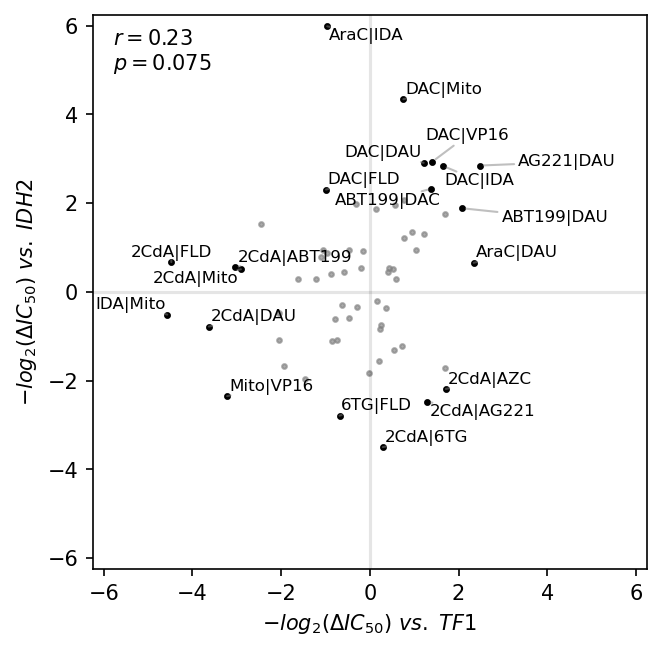

In [60]:
fig, ax = plt.subplots(1,1,dpi=150)
ax.scatter(df_comp['dIC50_x'], df_comp['dIC50_y'], alpha=0.65, s=5, color='gray')
ax.set_xlim([-6.25,6.25])
ax.set_ylim([-6.25,6.25])
ax.set_xlabel('$-log_2(\Delta IC_{50})~vs.~TF1$')
ax.set_ylabel('$-log_2(\Delta IC_{50})~vs.~IDH2$')
ax.set_aspect('equal')
r, p = sp.stats.pearsonr(df_comp['dIC50_x'], df_comp['dIC50_y'])
ax.text(-5.8,5, f'$r={r:.2}$\n$p={p:.2}$',fontsize=10)
xstd = np.std(df_comp['dIC50_x'])
ystd = np.std(df_comp['dIC50_y'])
xm = np.mean(df_comp['dIC50_x'])
ym = np.mean(df_comp['dIC50_y'])
# sign = df_comp[(df_comp['dIC50_x']>(xm+2*xstd)) | (df_comp['dIC50_x']<(xm-2*xstd)) |
#                (df_comp['dIC50_y']>(ym+2*ystd)) | (df_comp['dIC50_y']<(ym-2*ystd))]
sign = df_comp[(df_comp['dIC50_x']>(1.95)) | (df_comp['dIC50_x']<(-2.5)) |
               (df_comp['dIC50_y']>(2.1)) | (df_comp['dIC50_y']<(-2))]
ax.scatter(sign['dIC50_x'], sign['dIC50_y'], alpha=1, s=5, color='black')
labels = [ ax.text(sign.iloc[i,0], sign.iloc[i,1], sign.index[i][0]+'|'+sign.index[i][1], ha='center', va='center', fontdict={'size':8})
           for i in range(sign.shape[0]) ]
adjust_text(labels, lim=1000, precision=0.001, arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))
ax.plot([-7,7],[0,0],'-',color='black', alpha=0.1, zorder=1)
ax.plot([0,0],[-7,7],'-',color='black', alpha=0.1, zorder=1)
#ax.errorbar(xm, ym, ystd, xstd,color='black', alpha=0.5, capsize=5)
fig.savefig('/home/wak/toprak-lab/aml_drug_synergy/figures/Figure 4B. TF1 vs. IDH2 significant drug pairs.png', dpi=600)

In [60]:
sign

dIC50_x   dIC50_y
drugA  drugB                    
2CdA   6MP   -1.237212  0.915184
       AG221  1.293254 -2.477909
       AZC    1.713259 -0.619080
       AraC   1.704213 -0.009219
       DAC    0.764349  2.074564
       DAU   -3.631077 -0.205994
6TG    AG221 -0.678379  1.524087
       DAU   -1.473069 -0.878203
ABT199 DAC    1.388426  2.326955
       DAU    2.080073  1.885685
       Mito   1.686722  1.749674
       VP16   1.228933  1.305171
AG221  DAC    0.142412  1.873968
       IDA   -0.257196  1.990448
       MTX    0.162296  2.700898
       VP16   0.943569  1.355295
AraC   VP16  -1.096059  0.745443
DAC    FLD   -0.987841  2.307168
       IDA    1.642709  1.195539
       MTX   -0.605095  2.821859
       Mito   0.628632  1.002968
       VP16   1.408092  2.935308
Mito   VP16  -3.218105 -2.349922

In [34]:
def compare_two_cells(cell1,cell2,ax):
    dfi = df_max.groupby(['cell_line','drugA','drugB']).agg(lambda x: x)
    df_comp = pd.merge(dfi.loc[cell1], dfi.loc[cell2],on=['drugA','drugB'],how='inner')
    df_comp = df_comp[~pd.isna(df_comp['dIC50_x']) & ~pd.isna(df_comp['dIC50_y'])]

    ax.scatter(df_comp['dIC50_x'], df_comp['dIC50_y'], alpha=0.6)
    ax.set_xlim([-7,7])
    ax.set_ylim([-7,7])
    # print(sp.stats.pearsonr(df_comp['dIC50_x'], df_comp['dIC50_y']))
    xstd = np.std(df_comp['dIC50_x'])
    ystd = np.std(df_comp['dIC50_y'])
    xm = np.mean(df_comp['dIC50_x'])
    ym = np.mean(df_comp['dIC50_y'])
    # sign = df_comp[(df_comp['dIC50_x']>(xm+2*xstd)) | (df_comp['dIC50_x']<(xm-2*xstd)) |
    #                (df_comp['dIC50_y']>(ym+2*ystd)) | (df_comp['dIC50_y']<(ym-2*ystd))]
    sign = df_comp[(df_comp['dIC50_x']>(1.99)) | (df_comp['dIC50_x']<(-1.99)) |
                   (df_comp['dIC50_y']>(1.99)) | (df_comp['dIC50_y']<(-1.99))]
    labels = [ax.text(sign.iloc[i,0], sign.iloc[i,1], sign.index[i][0]+'|'+sign.index[i][1], ha='center', va='center')
              for i in range(sign.shape[0])]
    adjust_text(labels, ax=ax, lim=1000, arrowprops=dict(arrowstyle='-', color='gray', alpha=.5))
    # ax.errorbar(xm, ym, 2*ystd, 2*xstd,color='black', alpha=0.5, capsize=5)

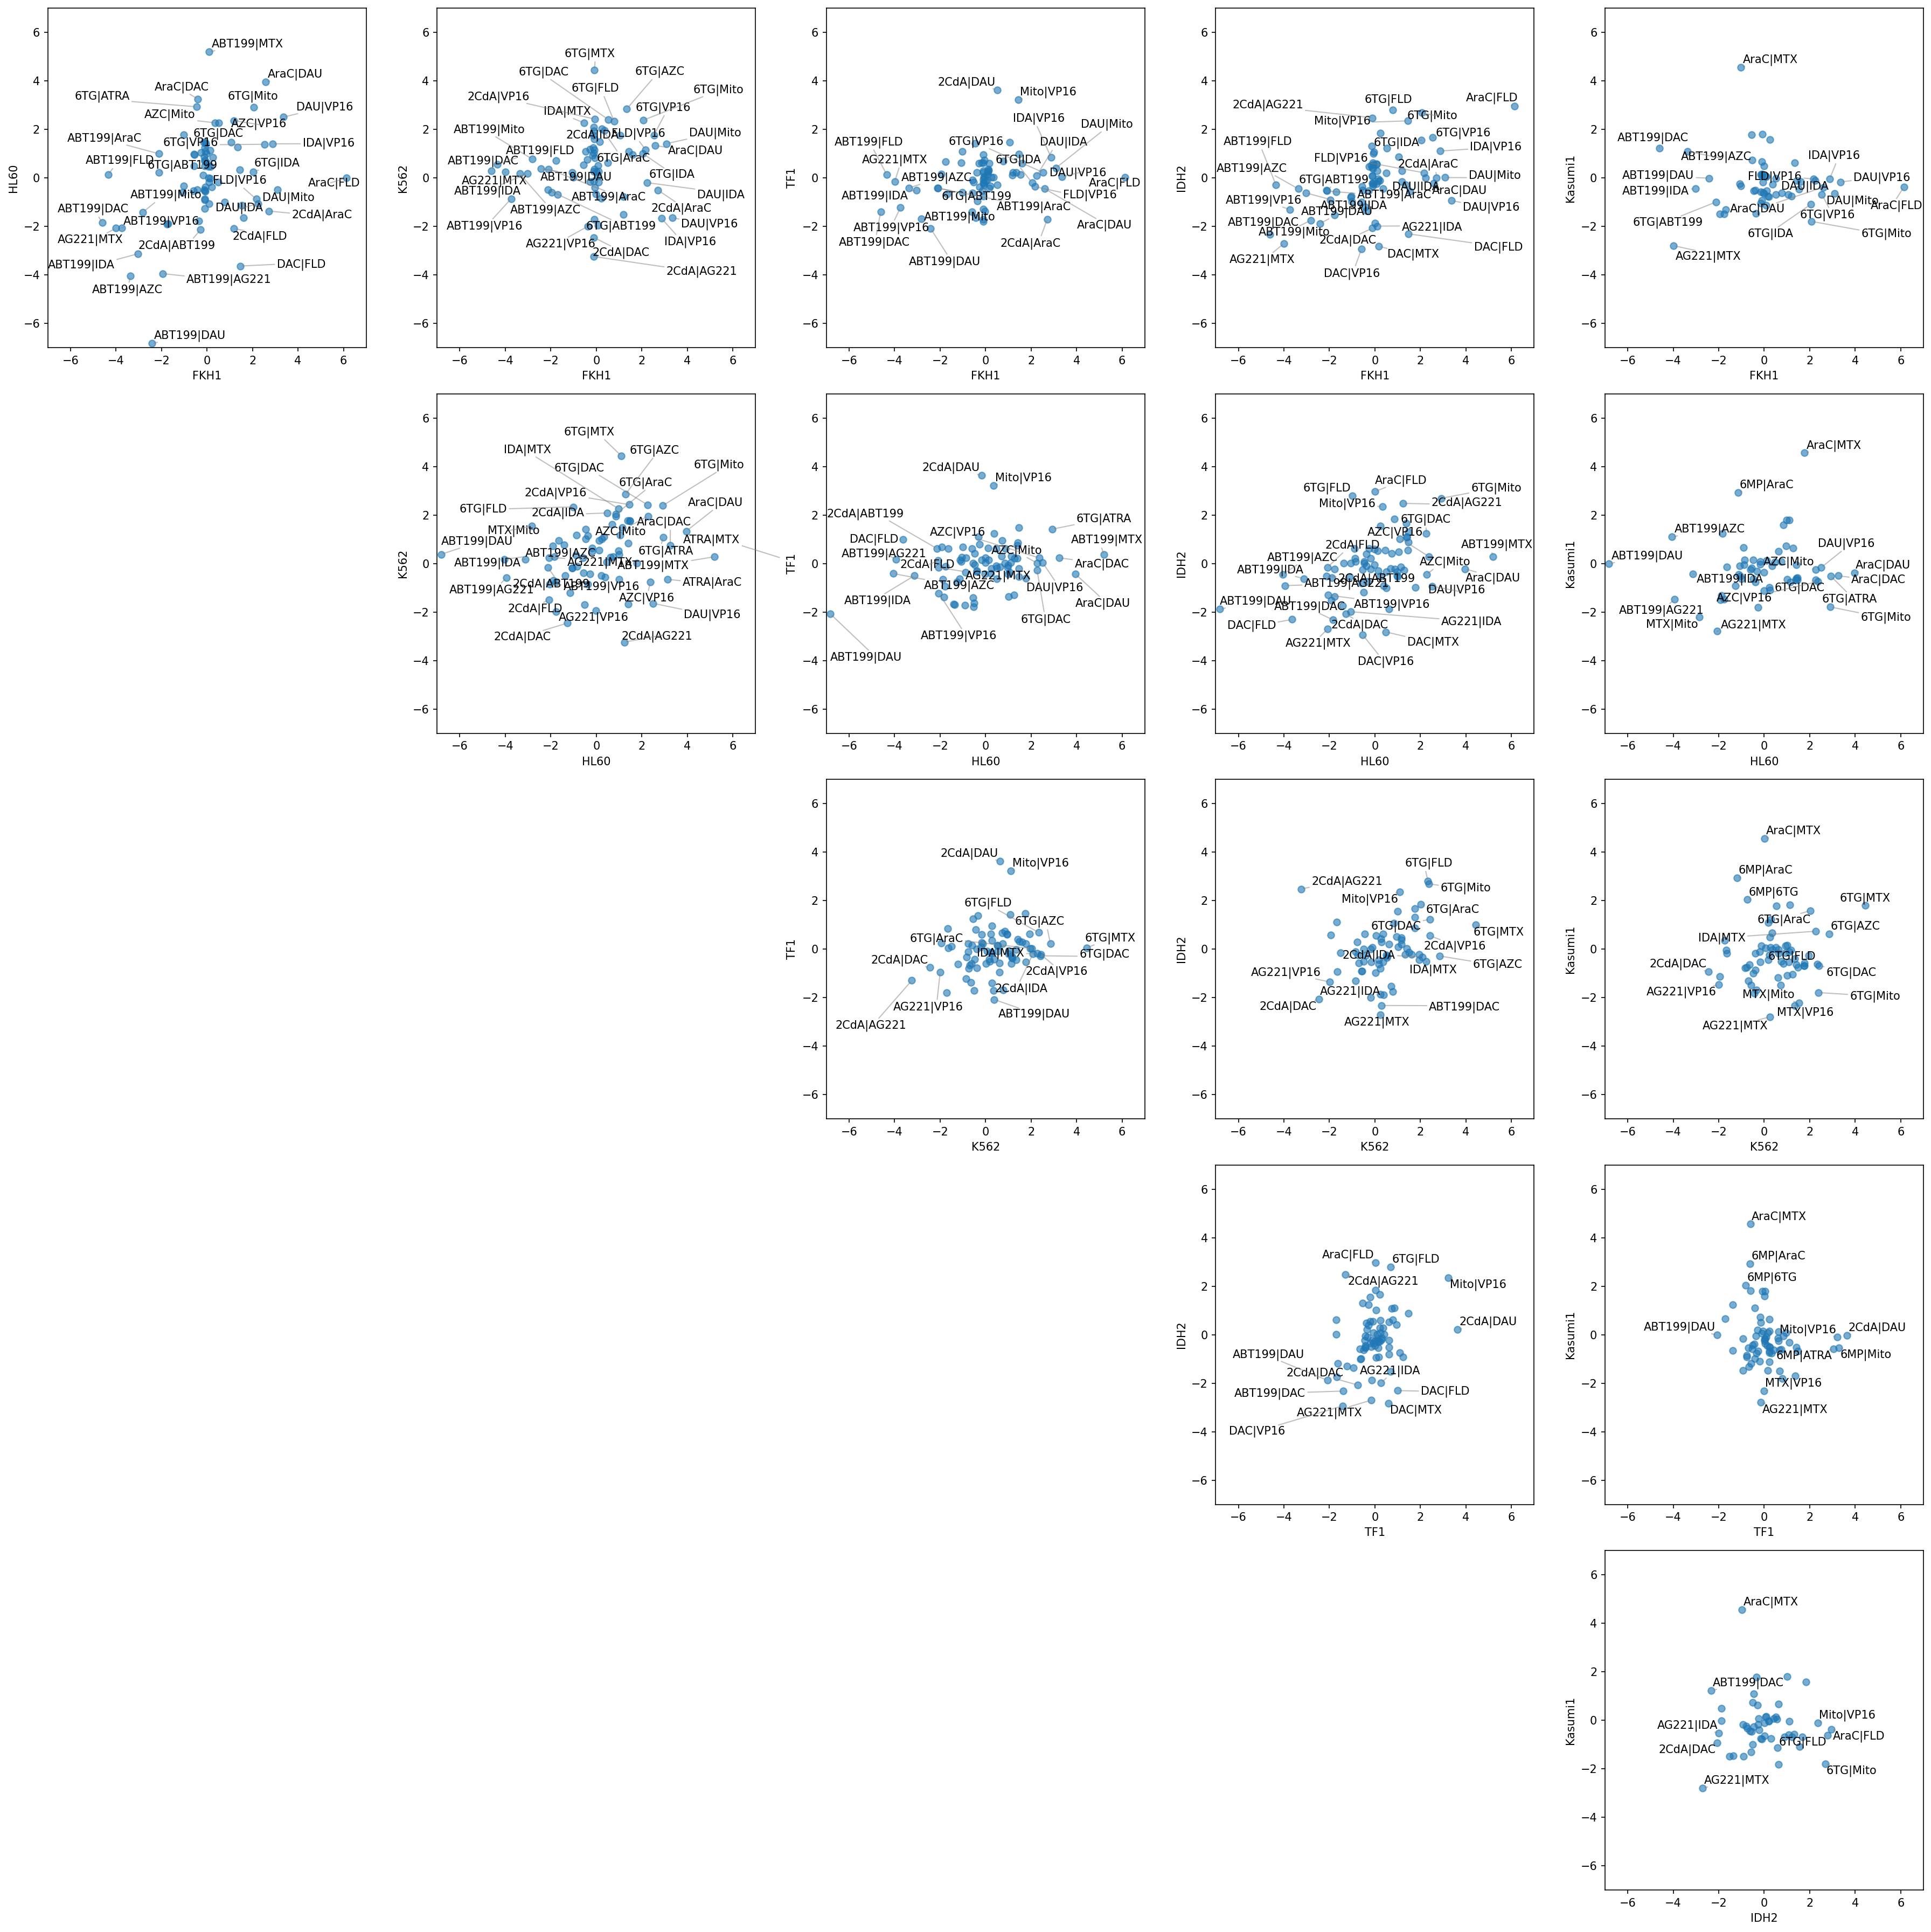

In [36]:
cells = df['cell_line'].unique()

fig, axes = plt.subplots(len(cells)-1,len(cells)-1,figsize=(24,24), dpi=150)
for i1,cell1 in enumerate(cells[:-1]):
    for i2,cell2 in enumerate(cells):
        ax = axes[i1,i2-1]
        if i2>i1:
            compare_two_cells(cell1,cell2,ax)
            ax.set_xlabel(cell1)
            ax.set_ylabel(cell2)
        elif i2>0:
            ax.set_axis_off()
fig.tight_layout()
fig.savefig('/home/wak/toprak-lab/aml_drug_synergy/dump/compare_dIC50_all_cell_lines.png',dpi=600)

In [29]:
adjust_text?

Signature:
adjust_text(
    texts,
    x=None,
    y=None,
    add_objects=None,
    ax=None,
    expand_text: 'float | tuple[float, float]' = (1.05, 1.2),
    expand_points: 'float | tuple[float, float]' = (1.05, 1.2),
    expand_objects: 'float | tuple[float, float]' = (1.05, 1.2),
    expand_align: 'float | tuple[float, float]' = (1.05, 1.2),
    autoalign='xy',
    va='center',
    ha='center',
    force_text: 'float | tuple[float, float]' = (0.1, 0.25),
    force_points: 'float | tuple[float, float]' = (0.2, 0.5),
    force_objects: 'float | tuple[float, float]' = (0.1, 0.25),
    lim=500,
    precision=0.01,
    only_move={'points': 'xy', 'text': 'xy', 'objects': 'xy'},
    avoid_text=True,
    avoid_points=True,
    avoid_self=True,
    save_steps=False,
    save_prefix='',
    save_format='png',
    add_step_numbers=True,
    *args,
    **kwargs,
)
Docstring:
Iteratively adjusts the locations of texts.

Call adjust_text the very last, after all plotting (especially
anything tha